The purpose of this project is to apply a KNN model to predict occurance of a wildfire, based on NASA satellite measurement data. In this notebook, I build a decision tree model, tune the relevant hyper parameters, and then identify feature importance in the tree's decision making.

In [1]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = "../data/final_combined_dataset.csv"
RANDOM_STATE = 1234
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Load dataset
data = pd.read_csv(DATA_PATH)

# Prepare features and target
# Dropping FIRE (target), Date (temporal), and location features (Longitude, Latitude)
X = data.drop(["FIRE", "Date", "Longitude", "Latitude"], axis=1)
y = data['FIRE']


/home/paul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Split data: first split into train_all and test
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Create validation set from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Display dataset shapes
print("Dataset splits:")
print(f"  Training set:   {X_train.shape}")
print(f"  Validation set: {X_val.shape}")
print(f"  Test set:       {X_test.shape}")
print(f"\nLabel shapes:")
print(f"  Training labels:   {y_train.shape}")
print(f"  Validation labels: {y_val.shape}")
print(f"  Test labels:       {y_test.shape}")

Dataset splits:
  Training set:   (19168, 10)
  Validation set: (4792, 10)
  Test set:       (5990, 10)

Label shapes:
  Training labels:   (19168,)
  Validation labels: (4792,)
  Test labels:       (5990,)


In [ ]:
# Scikit-learn imports for evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):

    rows = []
    for name, pipeline in pipelines:
        # Fit pipeline on training data
        pipeline.fit(X_train, y_train)
        
        # Generate predictions
        train_preds = pipeline.predict(X_train)
        eval_preds = pipeline.predict(X_evaluate)
        
        # Calculate metrics
        rows.append({
            'name': name,
            'Eval Accuracy': accuracy_score(y_evaluate, eval_preds),
            'Eval Recall': recall_score(y_evaluate, eval_preds),
            'Eval Precision': precision_score(y_evaluate, eval_preds),
            'Eval F1': f1_score(y_evaluate, eval_preds)
        })
    
    return pd.DataFrame(rows)

In [4]:
# Scikit-learn imports for KNN models
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# Initialize baseline KNN models
knn_baseline = KNeighborsClassifier()
scaler = MinMaxScaler()

# Create pipelines
knn_baseline_pipeline = make_pipeline(knn_baseline)
knn_scaled_pipeline = make_pipeline(scaler, KNeighborsClassifier())

In [5]:
# Evaluate baseline models on validation set
baseline_results = evaluate_pipelines([
    ('Baseline KNN', knn_baseline_pipeline),
    ('Scaled KNN', knn_scaled_pipeline)
], X_train, y_train, X_val, y_val)

display(baseline_results)

,name,Eval Accuracy,Eval Recall,Eval Precision,Eval F1
0,Baseline KNN,0.920701,0.944068,0.899838,0.921423
1,Scaled KNN,0.919240,0.932627,0.906134,0.919190


In [6]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Create pipeline for grid search
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 21)),  # k from 1 to 20
    'knn__weights': ['uniform', 'distance']   # weight schemes
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit to training data
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Display best parameters and score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.6f}")

# Evaluate on validation set
y_val_pred = grid_search.predict(X_val)
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

Performing grid search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/paul/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters: {'knn__n_neighbors': 17, 'knn__weights': 'distance'}
Best CV Accuracy: 0.926022

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2432
           1       0.91      0.95      0.93      2360

    accuracy                           0.93      4792
   macro avg       0.93      0.93      0.93      4792
weighted avg       0.93      0.93      0.93      4792



In [7]:
# Create tuned KNN model with best hyperparameters
BEST_N_NEIGHBORS = grid_search.best_params_['knn__n_neighbors']
BEST_WEIGHTS = grid_search.best_params_['knn__weights']

knn_tuned = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=BEST_N_NEIGHBORS, weights=BEST_WEIGHTS)
)

print(f"Tuned KNN model: n_neighbors={BEST_N_NEIGHBORS}, weights='{BEST_WEIGHTS}'")

Tuned KNN model: n_neighbors=17, weights='distance'


In [8]:
# Evaluate scaled and tuned models on test set
test_results = evaluate_pipelines([
    ('Scaled KNN', knn_scaled_pipeline),
    ('Tuned KNN', knn_tuned)
], X_train, y_train, X_test, y_test)

display(test_results)

,name,Eval Accuracy,Eval Recall,Eval Precision,Eval F1
0,Scaled KNN,0.920033,0.932561,0.906923,0.919563
1,Tuned KNN,0.924374,0.941757,0.907450,0.924285


Scaled KNN - Validation AUC-ROC: 0.967176


<Figure size 800x600 with 0 Axes>

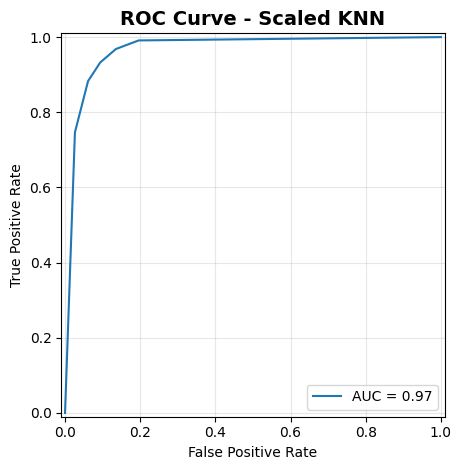

In [9]:
# Evaluate ROC-AUC for scaled KNN model
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# Get predicted probabilities for positive class
y_val_proba_scaled = knn_scaled_pipeline.predict_proba(X_val)[:, 1]

# Compute AUC-ROC
auc_score_scaled = roc_auc_score(y_val, y_val_proba_scaled)
print(f"Scaled KNN - Validation AUC-ROC: {auc_score_scaled:.6f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_scaled)

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score_scaled).plot()
plt.title("ROC Curve - Scaled KNN", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Tuned KNN - Validation AUC-ROC: 0.978099


<Figure size 800x600 with 0 Axes>

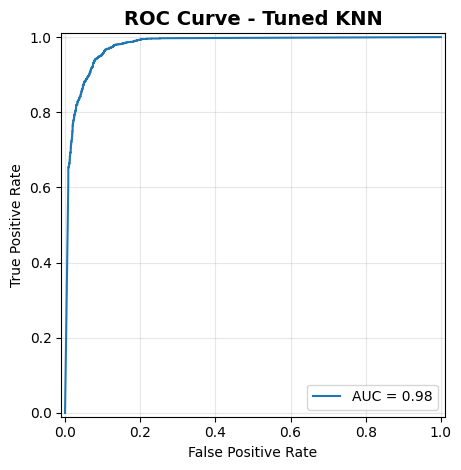

In [10]:
# Evaluate ROC-AUC for tuned KNN model
# Get predicted probabilities for positive class
y_val_proba_tuned = knn_tuned.predict_proba(X_val)[:, 1]

# Compute AUC-ROC
auc_score_tuned = roc_auc_score(y_val, y_val_proba_tuned)
print(f"Tuned KNN - Validation AUC-ROC: {auc_score_tuned:.6f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_tuned)

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score_tuned).plot()
plt.title("ROC Curve - Tuned KNN", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

# Create final model with best hyperparameters
final_knn = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=BEST_N_NEIGHBORS, weights=BEST_WEIGHTS)
)
final_knn.fit(X_train, y_train)

# Calculate permutation importance on validation set
print("Calculating permutation importance...")
perm = permutation_importance(
    final_knn,
    X_val,
    y_val,
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Format results as DataFrame
knn_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean,
    'Std': perm.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print("=" * 60)
print(knn_importance_df.to_string(index=False))


Calculating permutation importance...

Feature Importance (Permutation Importance):
           Feature  Importance      Std
                PS    0.352358 0.007266
              RH2M    0.023393 0.003009
            T2MDEW    0.012250 0.001962
           T2M_MAX    0.009286 0.001476
               T2M    0.008598 0.001812
           T2M_MIN    0.007471 0.001342
              WS2M    0.006052 0.001080
 ALLSKY_SFC_LW_DWN    0.005989 0.001018
ALLSKY_SFC_SW_DIFF    0.002108 0.000726
 ALLSKY_SFC_SW_DWN    0.000146 0.000324
